# IQ Mixing notes

https://markimicrowave.com/technical-resources/application-notes/how-to-think-about-iq-mixers/

In [1]:
%matplotlib widget
import niscope as ni

# Uscita trigger dal signal generator: Pulse Sync

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import os
import sys
sys.path.insert(1, '..\\Instruments\\network\\R&S_Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')
sys.path.insert(3, '..\\Instruments\\QuickSyn')
sys.path.insert(4, '..\\HDF5')

import RS_SMA100B
from Card_Class import *
from HDF5 import save_dict_to_hdf5 as hdf5_write

import FSL_0010

fsl = FSL_0010.FSL10_synthesizer(device_address='COM31')

In [2]:
ip              = '192.168.40.15'                                   # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

k = 4                                                               # coefficiente per prendere k*1000 punti 
                                                                    # con la scheda, dunque devo aumentare la pulse width e period

pulse_freq      = 1.010e9
amplitude       = -18                                               # Set the amplitude of the signal in dBm
sample_rate     = 250e6                                             # Maximum Value: 250.0e6

pulse_period     = k * 1e-6                                          # 4e-6 con 250e6 dà 1000 punti
num_pts         = int(sample_rate * pulse_period)                                         # min 5ns                             
pulse_delay     = 0

percent         = 5
pulse_width     = pulse_period * (1 - percent/100)                                          # min 20ns


sGen.reset()
sGen.clear()
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')
sGen.RF_freq(pulse_freq)
sGen.RF_lvl_ampl(amplitude)


# parameters for the Acquisition Card
pxie.voltage_range      = 0.5
pxie.coupling           = 'AC' # or DC????
# pxie.num_pts            = 1000
pxie.num_pts            = num_pts
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = sample_rate                               # Maximum Value: 250.0e6

SMA100B: Connection successful!
5170R: Available communication!


- P cycle: 0


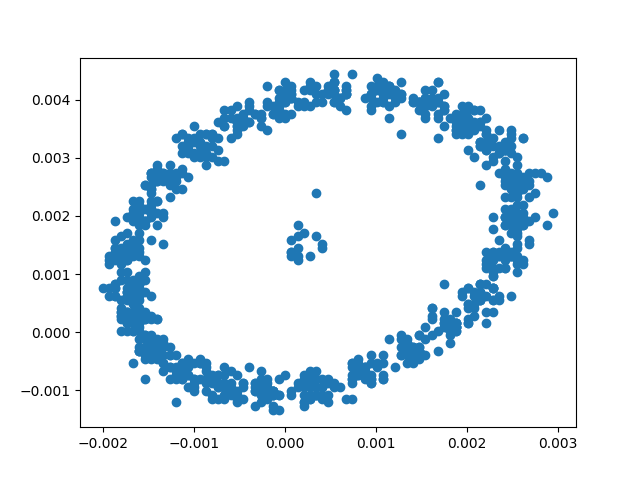

1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
- P cycle: 1
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
- P cycle: 2
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
- P cycle: 3
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
- P cycle: 4
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
- P cycle: 5
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
- P cycle: 6
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
- P cycle: 7
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
- P cycle: 8
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
- P cycle: 9
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


In [3]:
# FSL-0010
fsl.set_frequency(1) # GHz
fsl.set_output('ON')
pxie.open(trigger_channel = '0')

pota        = np.arange(amplitude, amplitude + 10 , 1)
pula        = np.arange(pulse_freq, pulse_freq + 0.010e9, 0.001e9)

amplidick   = {}
counter     = 1


digits_p = "{:0"+str(len(str(len(pota))))+"d}"
digits_f = "{:0"+str(len(str(len(pula))))+"d}"
for p, pot in enumerate(pota):
    print('- P cycle:', p)
    amplidick[f'p{digits_p.format(p)}'] = {'power_(dBm)': pot, 'freqs': {}}
    sGen.RF_lvl_ampl(pot)

    for i, pul in enumerate(pula):
        
        sGen.RF_freq(pul) # guarda come è definito, abbiamo messo la potenza e6   
        sGen.pul_state(1)
        sGen.RF_state(1)
        # time.sleep(0.1)
        waveforms = pxie.acquisition(sGen.pul_exe_sing_trig)
        I = np.array(waveforms[3].samples.tolist())
        Q = np.array(waveforms[2].samples.tolist())
        if p == 0 and i == 0:

          cln_pts = 30                # clean points for I-Q plane
          plt.clf()
          plt.scatter(Q[cln_pts:-cln_pts],I[cln_pts:-cln_pts])
          plt.show()
        
        
        sGen.pul_state(0)
        sGen.RF_state(0)

        print(int(counter*100/(len(pota)*len(pula))),'%')
        counter += 1
        amplidick[f'p{digits_p.format(p)}']['freqs'][f'f{digits_f.format(i)}'] = {'freq_(Hz)': pul, 'I': I, 'Q': Q}
fsl.set_output('OFF')


# SAVE DATA ON HDF5 FILE
filename = 'amplitrixCASA_IQMixer.hdf5'
if os.path.exists(filename):
  os.remove(filename)
hdf5_write(amplidick, filename)

In [4]:
# Turn ON the modulation of the Signal Generator
# sGen.pul_state(1)
# sGen.RF_state(1)


# FSL-0010
# fsl.set_frequency(1) # GHz
# fsl.set_output('ON')




with ni.Session("PXI1Slot3") as session: # Name of the device
    session.reset_with_defaults()
    session.channels[0].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # I
    session.channels[2].configure_vertical(range=2.0, coupling=ni.VerticalCoupling.AC) # Q
    session.configure_horizontal_timing(
        min_sample_rate     = 250e6, 
        min_num_pts         = int(1000*k), 
        ref_position        = 0, 
        num_records         = 1, 
        enforce_realtime    = True
        )

    session.configure_trigger_digital(
        trigger_source      = '0', 
        slope               = ni.TriggerSlope.POSITIVE, 
        holdoff             = 0, 
        delay               = 0
        )

    with session.initiate():
        waveforms = session.channels[0, 2].fetch()
        #waveforms = session.channels[0].fetch()
    for wfm in waveforms:
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))
        print('Channel {0}, record {1} samples acquired: {2:,}\n'.format(wfm.channel, wfm.record, len(wfm.samples)))

fsl.set_output('OFF')
sGen.pul_state(0)
sGen.RF_state(0)

a = np.array(waveforms[0].samples.tolist())
b = np.array(waveforms[1].samples.tolist())


plt.figure()
#plt.plot(np.arange(len(a))/250e6, 20*np.log10(np.array(a)**2 + np.array(b)**2))
plt.plot(np.arange(len(a))/250e6, np.sqrt(np.array(a)**2 + np.array(b)**2))
#plt.plot(np.arange(len(a))/250e6, np.arctan(np.array(b)/np.array(a)))
#plt.plot(np.arange(len(a))/250e6, np.array(a))
plt.show()

DriverError: -1074126845: Maximum time exceeded before the operation completed.

Device: PXI1Slot3


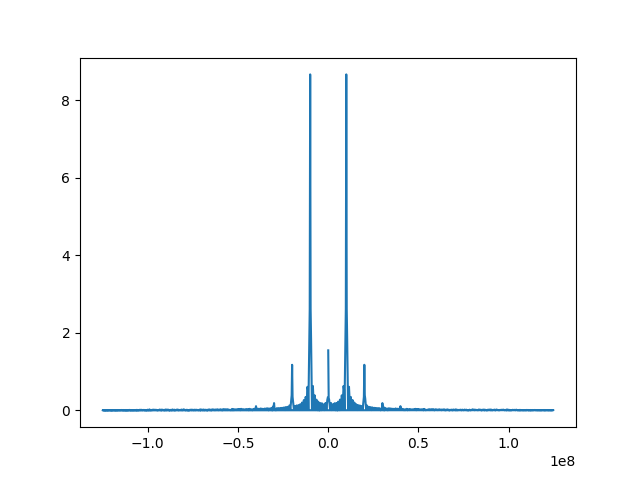

In [ ]:
def weight_factor (ft, range_mask):
    # tot_int = np.trapz(ft)
    tot_int = np.sum(ft)
    ft[~range_mask] = 0
    # portion = np.trapz(ft)
    portion = np.sum(ft)

    return tot_int/portion

def data_fft(y: np.array, freq, sample_rate, toggle_plot = True):
    N = len(y)
    T = 1/sample_rate
    FT = np.fft.fft(y)
    PHI = np.unwrap(np.angle(FT))

    x = np.arange(len(y))/sample_rate
    freqs = np.fft.fftfreq(N,T) 
    offset = 5e6

    if toggle_plot:
        plt.clf()
        
       
        plt.plot(freqs,np.abs(FT))
        plt.show()
    
data_fft(a, 80e6, sample_rate, True)

Dai test sembra che non servano attenuazioni quando il segnale passa per il mixer, ma è necessaerio capire quanta potenza effettivamente arriva alla scheda per non friggerla.

## DOVREMO fare la CARATTERIZZAZIONE DELL'IQ-MIXER

Studiare range di ampiezze in cui opera e magari anhe range di frequenze.
Studiare Attenuazione che dà?

Nel piano I-q non compare una circonferenza precisa, ma è più un'ellisse. Studiare e magari richiedere.

Preparare i programmi, anche per l'analisi dati in loco per risparmiare tempo.

# Scrivere una manuale per la pixie, in particolare per l'uso del trigger esterno.